In [1]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding,GRU
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from keras.models import load_model
from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

## Read  Dataset

In [2]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


## Split Dataset Train & Validation

In [3]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [4]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [5]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [6]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [7]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [9]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [10]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

## Hyperparameters

In [11]:
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
number_of_units=50
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=0.2

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(model_FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)
nadam = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [13]:
model = Sequential()
model.add(GRU(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                11400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1377      
Total params: 12,777
Trainable params: 12,777
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
#Time to train

start_time = time.time()




history=model.fit(X_train, Y_train, epochs=Epochs, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))






Train on 216000 samples, validate on 54000 samples
Epoch 1/30
216000/216000 [==============================] - 144s 668us/step - loss: 2.6567 - acc: 0.1948 - val_loss: 2.3402 - val_acc: 0.2637

Epoch 00001: val_acc improved from -inf to 0.26369, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/30
216000/216000 [==============================] - 142s 659us/step - loss: 2.2782 - acc: 0.2822 - val_loss: 2.1718 - val_acc: 0.2960

Epoch 00002: val_acc improved from 0.26369 to 0.29596, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/30
216000/216000 [==============================] - 175s 810us/step - loss: 2.1659 - acc: 0.3117 - val_loss: 2.0709 - val_acc: 0.3418

Epoch 00003: val_acc improved from 0.29596 to 0.34180, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/30
216000/216000 [==============================] - 164s 759us/step - loss: 2.0829 - acc: 0.3385 - val_loss: 1.9887 - val_acc: 0.353182

Epoch 00004: val_acc improved from 0.34

In [15]:
model.save(model_FileName[:-3])  # creates a HDF5 file 'my_model.h5'


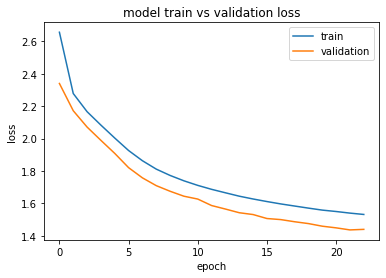

In [16]:


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
 

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

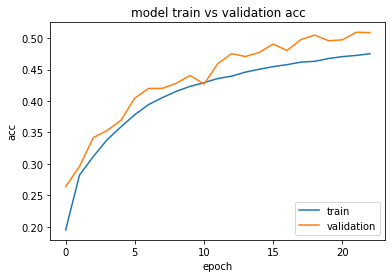

In [17]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [18]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [19]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [20]:
Y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## TEST DEĞERLENDİRME

In [21]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
predicted = model.predict(X_test)

81000/81000 [==============================] - 13s 165us/step
Loss for testing = 1.4670140844781274 and Accuracy for testing = 0.5060864221654189


In [22]:
(predicted.shape)

(81000, 27)

In [23]:
#predicted = model.predict(X_test)

In [24]:
(predicted.shape)

(81000, 27)

### grafik mırafik

In [25]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return df_confusion

In [26]:
predicted

array([[1.0000000e+00, 4.3232429e-35, 8.3436934e-37, ..., 0.0000000e+00,
        0.0000000e+00, 7.2320149e-26],
       [9.4094253e-01, 5.4319832e-04, 5.9871113e-09, ..., 5.6478239e-10,
        4.6703499e-09, 1.0323428e-09],
       [1.0709956e-01, 9.7374991e-03, 5.5512664e-06, ..., 3.6709253e-02,
        4.1089233e-02, 2.2161764e-01],
       ...,
       [9.5027275e-02, 8.7615298e-03, 6.6278835e-06, ..., 3.2706112e-02,
        4.0727086e-02, 3.2210261e-01],
       [1.6951212e-01, 9.2900181e-03, 9.3402970e-04, ..., 9.3821628e-04,
        7.4741221e-03, 5.8710255e-02],
       [9.5047832e-02, 8.7593878e-03, 6.6263547e-06, ..., 3.2703135e-02,
        4.0724102e-02, 3.2208729e-01]], dtype=float32)

In [27]:
print(predicted.shape, Y_test.shape)

(81000, 27) (81000, 27)


Average F1 score is 0.4825114145065862
Confusion matrix: 
 Predicted    0     1     2     3    4    5   6     7    8     9   ...   17  \
Actual                                                            ...        
0          1221     0     0     0    0    0   0     0    0     0  ...  130   
1             1  1928   131     0   17    9  87   356    7    39  ...   12   
2            19     0  1814     0    0    0   0     0    0   901  ...   48   
3            32     5    23  2835    0    0   0     0   11    38  ...    0   
4             7   381     5     0  772  329   3   876   89     1  ...    4   
5            15   326    34    13  129   21  35  1867  169    16  ...    5   
6             9   284    68    15   91   43  53  1733  196    10  ...    9   
7             6   234    41     4  235   49  15  1711  194    32  ...    7   
8            10   326    68    30  110   34  57  1750  225    14  ...    6   
9            41     0   846     0    0    0   0     0    0  1700  ...   58   
10   

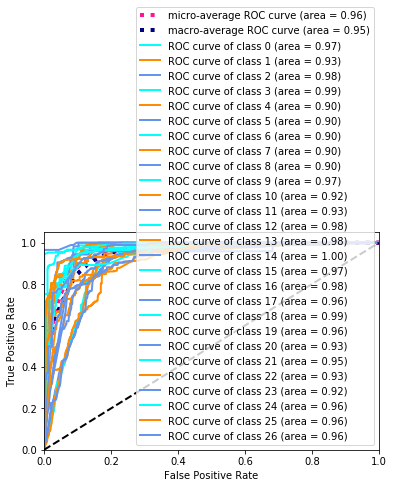

In [28]:
df=compute_metrics(predicted, Y_test)

In [29]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [30]:
cm=matrix

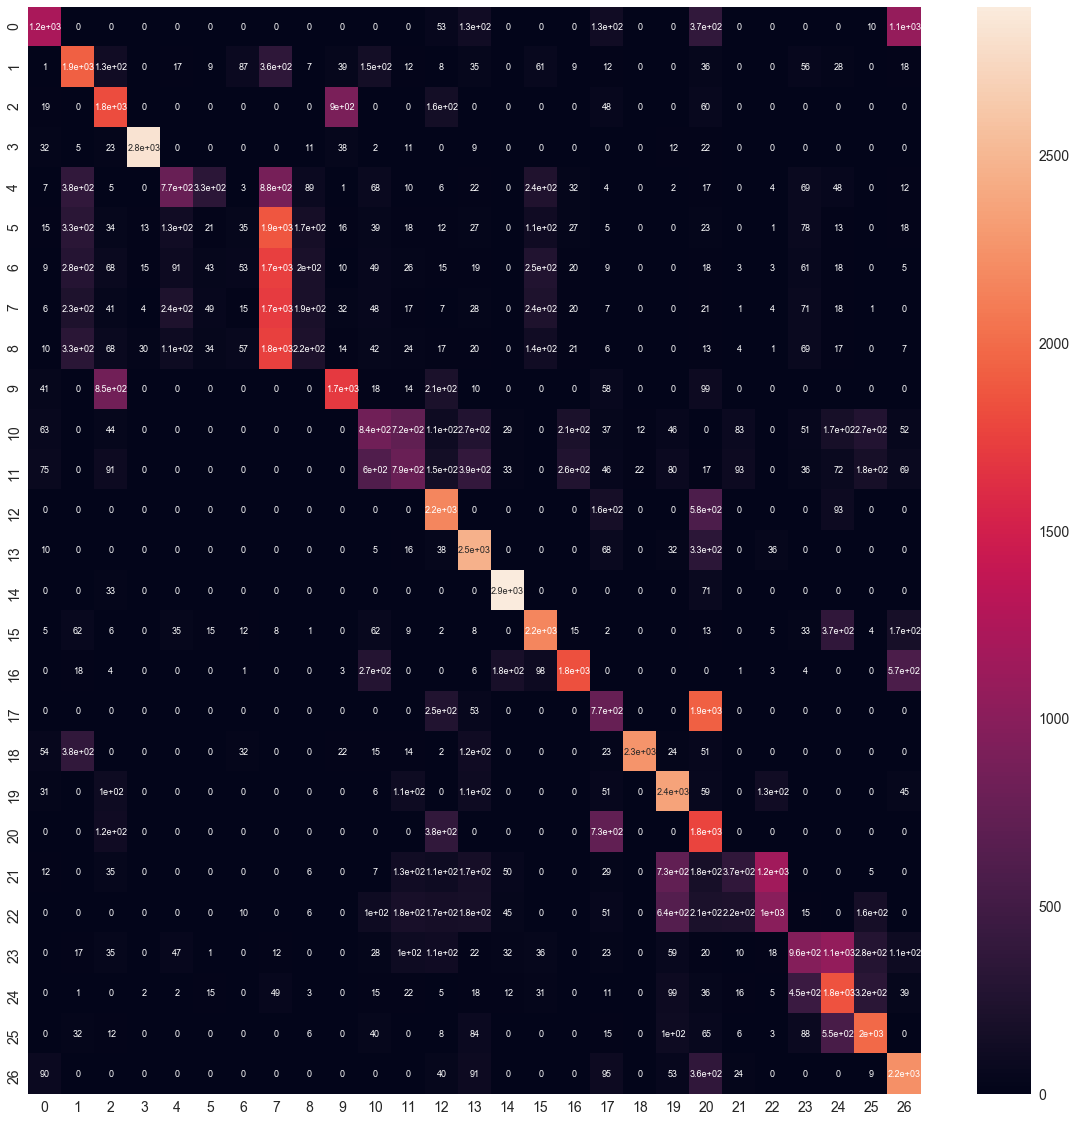

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

 ## blove part taken from https://www.python-course.eu/confusion_matrix.php

In [32]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     0.718  0.407  0.519
    1     0.482  0.643  0.551
    2     0.516  0.605  0.557
    3     0.978  0.945  0.961
    4     0.537  0.257  0.348
    5     0.041  0.007  0.012
    6     0.174  0.018  0.032
    7     0.205  0.570  0.301
    8     0.246  0.075  0.115
    9     0.612  0.567  0.589
   10     0.347  0.279  0.309
   11     0.353  0.264  0.302
   12     0.537  0.721  0.616
   13     0.576  0.821  0.677
   14     0.883  0.965  0.923
   15     0.642  0.722  0.680
   16     0.751  0.614  0.676
   17     0.321  0.256  0.285
   18     0.985  0.752  0.853
   19     0.555  0.785  0.650
   20     0.277  0.589  0.377
   21     0.449  0.124  0.195
   22     0.423  0.335  0.374
   23     0.471  0.321  0.382
   24     0.429  0.616  0.506
   25     0.616  0.663  0.639
   26     0.504  0.745  0.602


In [33]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

0.5060864197530864

## MODEL SAVING RELOADING

In [34]:
from keras.models import load_model
model.save(model_FileName)  # creates a HDF5 file 'my_model.h5'



In [35]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')

OSError: Unable to open file (unable to open file: name = '54.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
len(predicted)

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:


ths =open( "y_and_p_compare.csv", "w")


counter=-1
for i in range (len(predicted)):
    float_formatter = "{:.2f}".format
    print(Y_test[i],predicted[i])
    
    y= str(counter)+"-"+str(i)+"-            "+str(Y_test[i])
    y=y.replace("\n","")
    y=y+"\n"
    p=  str(counter)+"-"+str(i)+"-            "+str(predicted[i])
    p=p.replace("\n","")
    p=p+"\n"
    ths.write(y)
    ths.write(p)
    ths.write("\n")
    
    if i%50==0:
        counter=counter+1
        print(counter)
ths.close()        